# Campaign Response Prediction
## Preliminary Models
## importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import plot_tree
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from scipy.stats import uniform
%matplotlib inline

In [2]:
pd.set_option('display.max_columns', None)
df = pd.read_csv('superstore_data_clean.csv')

Separate the target variable from the rest of the dataset

In [3]:
X = df.drop(columns=['Response'])
y= df['Response']

## Detect Key Factors 
Training a random forest model on the entire dataset to get feature importance

In [4]:
rf_all = RandomForestClassifier(n_estimators = 100, random_state=10)
rf_all.fit(X, y)
rf_all_y_pred = rf_all.predict(X)

In [5]:
print(classification_report(y, rf_all_y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1906
           1       0.99      0.96      0.97       334

    accuracy                           0.99      2240
   macro avg       0.99      0.98      0.98      2240
weighted avg       0.99      0.99      0.99      2240



based on the findings the top few features are Recency, income, A few differenct procuct purchases and tenure.

In [6]:
columns = X.columns
feature_imp = pd.Series(rf_all.feature_importances_, index = columns).sort_values(ascending = False)
feature_imp_df = pd.DataFrame({'Feature': feature_imp.index, 'Importance': feature_imp.values*100})
feature_imp_df['Importance'] = feature_imp_df['Importance'].apply(lambda x: f'{x:.3f}%')

feature_imp_df

,Feature,Importance
0,Recency,10.164%
1,Income,9.017%
2,MntWines,8.888%
3,MntMeatProducts,8.128%
4,Tenure,7.859%
5,MntGoldProds,6.309%
6,Age,5.118%
7,NumCatalogPurchases,4.921%
8,MntFishProducts,4.783%
9,MntSweetProducts,4.730%


Split the data into train and test sets. 

70% is used for the training

maintained a similar ratio of positive to negative as the original dataset

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [8]:
count_yes_train = np.sum(y_train == 1)
count_no_train = np.sum(y_train == 0)
total_count_train = y_train.size
percentage_yes_train = (count_yes_train / total_count_train) * 100
percentage_no_train = (count_no_train / total_count_train) * 100

# Calculate counts and percentages for y_test
count_yes_test = np.sum(y_test == 1)
count_no_test = np.sum(y_test == 0)
total_count_test = y_test.size
percentage_yes_test = (count_yes_test / total_count_test) * 100
percentage_no_test = (count_no_test / total_count_test) * 100

# Print the results for y_train
print("Results for y_train:")
print(f"Percentage of 'yes': {percentage_yes_train:.2f}%")
print(f"Percentage of 'no': {percentage_no_train:.2f}%")
print()

# Print the results for y_test
print("Results for y_test:")
print(f"Percentage of 'yes': {percentage_yes_test:.2f}%")
print(f"Percentage of 'no': {percentage_no_test:.2f}%")

Results for y_train:
Percentage of 'yes': 14.67%
Percentage of 'no': 85.33%

Results for y_test:
Percentage of 'yes': 15.48%
Percentage of 'no': 84.52%


## Test a few different models and compare results

view the classification report and confusion matrix for a breakdown of the results

Random Forest Classifier

In [9]:
rf = RandomForestClassifier(n_estimators = 100, random_state=10)
rf.fit(X_train, y_train)
rf_y_pred = rf.predict(X_test)
rf_report = classification_report(y_test, rf_y_pred, output_dict=True)
print(classification_report(y_test, rf_y_pred))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93       568
           1       0.79      0.26      0.39       104

    accuracy                           0.88       672
   macro avg       0.84      0.62      0.66       672
weighted avg       0.87      0.88      0.85       672



In [10]:
print(classification_report(y_train, rf.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1338
           1       0.99      0.97      0.98       230

    accuracy                           0.99      1568
   macro avg       0.99      0.99      0.99      1568
weighted avg       0.99      0.99      0.99      1568



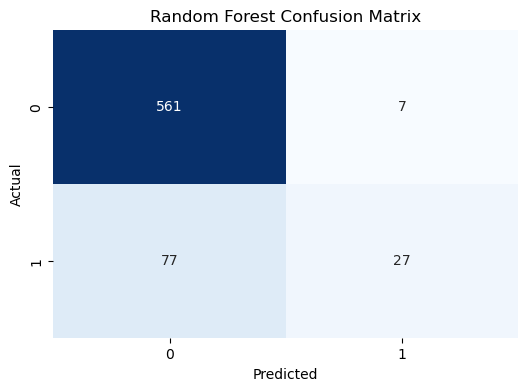

In [11]:
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, rf_y_pred), annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

XGBoost Classifier

In [12]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, seed=10)
xgb_model.fit(X_train, y_train)
xgb_y_pred = xgb_model.predict(X_test)
xgb_report = classification_report(y_test, xgb_y_pred, output_dict=True)
print(classification_report(y_test, xgb_y_pred))

              precision    recall  f1-score   support

           0       0.90      0.95      0.92       568
           1       0.62      0.40      0.49       104

    accuracy                           0.87       672
   macro avg       0.76      0.68      0.71       672
weighted avg       0.85      0.87      0.86       672



In [13]:
print(classification_report(y_train, xgb_model.predict(X_train)))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1338
           1       0.99      0.97      0.98       230

    accuracy                           0.99      1568
   macro avg       0.99      0.98      0.99      1568
weighted avg       0.99      0.99      0.99      1568



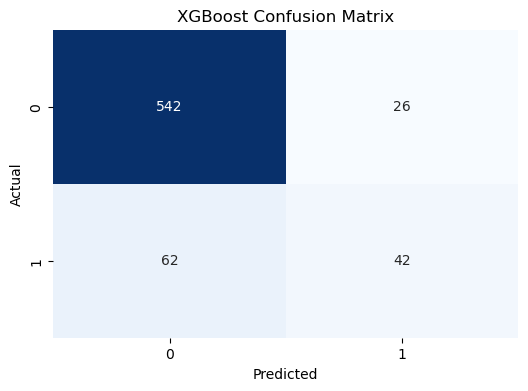

In [14]:
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, xgb_y_pred), annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])
plt.title('XGBoost Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

SVM Classifier

    Removed a few columns that are strongly correlated to each other and to the income feature.

    Scaled the data with robust scaling

In [15]:
X_reduce = X.drop(columns = ['MntMeatProducts','MntFishProducts','MntSweetProducts','MntFruits','Complain'])

In [16]:
X_train_red, X_test_red, y_train_red, y_test_red = train_test_split(X_reduce, y, test_size=0.3, random_state=10)
scaler = RobustScaler()
scaler.fit(X_train_red)
X_train_scaled = scaler.transform(X_train_red)
X_test_scaled = scaler.transform(X_test_red)

In [17]:
svm_classifier = SVC(random_state=10, probability=True)
svm_classifier.fit(X_train_scaled, y_train_red)
svm_y_pred = svm_classifier.predict(X_test_scaled)
svm_report = classification_report(y_test_red, svm_y_pred, output_dict=True)
print(classification_report(y_test_red, svm_y_pred))

              precision    recall  f1-score   support

           0       0.87      0.99      0.93       568
           1       0.87      0.19      0.31       104

    accuracy                           0.87       672
   macro avg       0.87      0.59      0.62       672
weighted avg       0.87      0.87      0.83       672



In [18]:
print(classification_report(y_train, svm_classifier.predict(X_train_scaled)))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      1338
           1       0.91      0.26      0.41       230

    accuracy                           0.89      1568
   macro avg       0.90      0.63      0.67      1568
weighted avg       0.89      0.89      0.86      1568



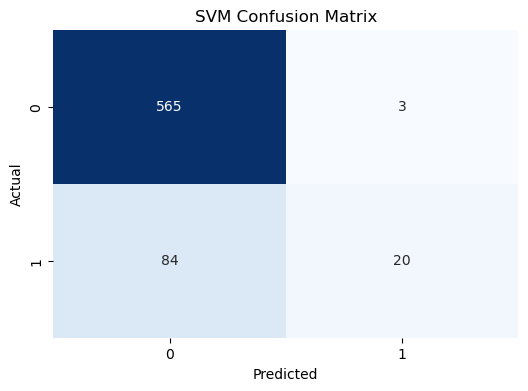

In [19]:
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test_red, svm_y_pred), annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Compiled the important results into a data frame for easy understanding

None of the models do well as the data is imbalanced in favor of class 0

In [20]:
results = {
    'Model': ['Random Forest', 'SVM', 'XGBoost'],
    'Accuracy': [accuracy_score(y_test, rf_y_pred), accuracy_score(y_test, svm_y_pred), accuracy_score(y_test, xgb_y_pred)],
    'Precision (Class 1)': [rf_report['1']['precision'], svm_report['1']['precision'], xgb_report['1']['precision']],
    'Recall (Class 1)': [rf_report['1']['recall'], svm_report['1']['recall'], xgb_report['1']['recall']],
    'F1-score (Class 1)': [rf_report['1']['f1-score'], svm_report['1']['f1-score'], xgb_report['1']['f1-score']]
}
results_df = pd.DataFrame(results)
results_df

,Model,Accuracy,Precision (Class 1),Recall (Class 1),F1-score (Class 1)
0,Random Forest,0.875000,0.794118,0.259615,0.391304
1,SVM,0.870536,0.869565,0.192308,0.314961
2,XGBoost,0.869048,0.617647,0.403846,0.488372


## Balance the data using Smote

balance the data with smote. Increased the minority class to 75% of the majority class

In [21]:
smote = SMOTE(sampling_strategy=0.75,random_state=9)
X_balance, y_balance = smote.fit_resample(X, y)

split the new data into test and train. 70% used for training

maintained a similar ratio of positive to negative as the original dataset

In [22]:
X_bal_train, X_bal_test, y_bal_train, y_bal_test = train_test_split(X_balance, y_balance, test_size=0.3, random_state=10)

In [23]:
count_yes_train = np.sum(y_bal_train == 1)
count_no_train = np.sum(y_bal_train == 0)
total_count_train = y_bal_train.size
percentage_yes_train = (count_yes_train / total_count_train) * 100
percentage_no_train = (count_no_train / total_count_train) * 100

# Calculate counts and percentages for y_test
count_yes_test = np.sum(y_bal_test == 1)
count_no_test = np.sum(y_bal_test == 0)
total_count_test = y_bal_test.size
percentage_yes_test = (count_yes_test / total_count_test) * 100
percentage_no_test = (count_no_test / total_count_test) * 100

# Print the results for y_train
print("Results for y_train:")
print(f"Percentage of 'yes': {percentage_yes_train:.2f}%")
print(f"Percentage of 'no': {percentage_no_train:.2f}%")
print()

# Print the results for y_test
print("Results for y_test:")
print(f"Percentage of 'yes': {percentage_yes_test:.2f}%")
print(f"Percentage of 'no': {percentage_no_test:.2f}%")

Results for y_train:
Percentage of 'yes': 43.23%
Percentage of 'no': 56.77%

Results for y_test:
Percentage of 'yes': 41.96%
Percentage of 'no': 58.04%


## Rerun the models and compare results
view the classification report and confusion matrix for a breakdown of the results

Random Forest Classifier 

In [24]:
rf_bal = RandomForestClassifier(n_estimators = 100, random_state=10)
rf_bal.fit(X_bal_train, y_bal_train)
rf_bal_y_pred = rf_bal.predict(X_bal_test)
rf_bal_report = classification_report(y_bal_test, rf_bal_y_pred, output_dict=True)
print(classification_report(y_bal_test, rf_bal_y_pred))

              precision    recall  f1-score   support

           0       0.92      0.95      0.93       581
           1       0.93      0.89      0.91       420

    accuracy                           0.92      1001
   macro avg       0.92      0.92      0.92      1001
weighted avg       0.92      0.92      0.92      1001



In [25]:
print(classification_report(y_bal_train, rf_bal.predict(X_bal_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1325
           1       1.00      0.99      0.99      1009

    accuracy                           1.00      2334
   macro avg       1.00      1.00      1.00      2334
weighted avg       1.00      1.00      1.00      2334



Feature importance of the model

In [26]:
columns = X.columns
feature_imp = pd.Series(rf_bal.feature_importances_, index = columns).sort_values(ascending = False)
feature_imp_df = pd.DataFrame({'Feature': feature_imp.index, 'Importance': feature_imp.values*100})
feature_imp_df['Importance'] = feature_imp_df['Importance'].apply(lambda x: f'{x:.3f}%')

feature_imp_df

,Feature,Importance
0,Recency,9.988%
1,Income,7.388%
2,MntGoldProds,7.097%
3,Tenure,7.061%
4,MntMeatProducts,6.973%
5,MntWines,6.824%
6,Marital_Status_Married,6.013%
7,Marital_Status_Single,4.991%
8,NumStorePurchases,4.650%
9,Marital_Status_Together,4.342%


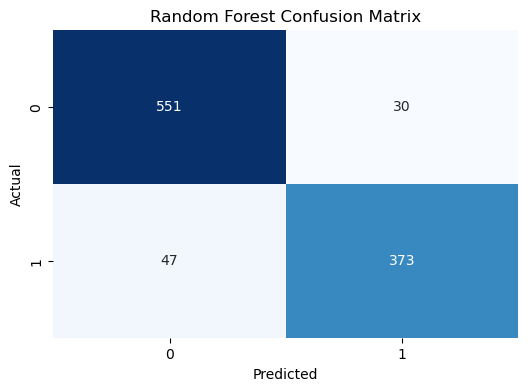

In [27]:
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_bal_test, rf_bal_y_pred), annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

XGBoost Classifier

In [28]:
xgb_bal_model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, seed=10)
xgb_bal_model.fit(X_bal_train, y_bal_train)
xgb_bal_y_pred = xgb_bal_model.predict(X_bal_test)
xgb_bal_report = classification_report(y_bal_test, xgb_bal_y_pred, output_dict=True)
print(classification_report(y_bal_test, xgb_bal_y_pred))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       581
           1       0.89      0.89      0.89       420

    accuracy                           0.91      1001
   macro avg       0.91      0.91      0.91      1001
weighted avg       0.91      0.91      0.91      1001



In [29]:
print(classification_report(y_bal_train, xgb_bal_model.predict(X_bal_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1325
           1       1.00      0.99      0.99      1009

    accuracy                           1.00      2334
   macro avg       1.00      1.00      1.00      2334
weighted avg       1.00      1.00      1.00      2334



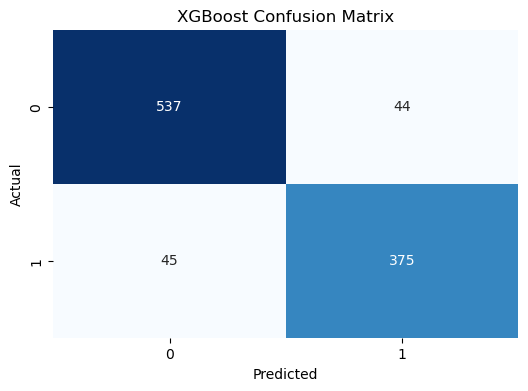

In [30]:
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_bal_test, xgb_bal_y_pred), annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])
plt.title('XGBoost Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

SVM classifer

Removed highly correlated columns and scaled the data

In [31]:
X_bal_reduce = X_balance.drop(columns = ['MntMeatProducts','MntFishProducts','MntSweetProducts','MntFruits','Complain'])

X_bal_train_red, X_bal_test_red, y_bal_train_red, y_bal_test_red = train_test_split(X_bal_reduce, y_balance, test_size=0.3, random_state=10)
scaler = RobustScaler()
scaler.fit(X_bal_train_red)
X_bal_train_scaled = scaler.transform(X_bal_train_red)
X_bal_test_scaled = scaler.transform(X_bal_test_red)

In [32]:
svm_classifier_bal = SVC(random_state=10, probability=True)
svm_classifier_bal.fit(X_bal_train_scaled, y_bal_train_red)
svm_bal_y_pred = svm_classifier_bal.predict(X_bal_test_scaled)
svm_bal_report = classification_report(y_bal_test_red, svm_bal_y_pred, output_dict=True)
print(classification_report(y_bal_test_red, svm_bal_y_pred))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       581
           1       0.86      0.86      0.86       420

    accuracy                           0.89      1001
   macro avg       0.88      0.88      0.88      1001
weighted avg       0.89      0.89      0.89      1001



In [33]:
print(classification_report(y_bal_train, svm_classifier_bal.predict(X_bal_train_scaled)))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      1325
           1       0.90      0.91      0.91      1009

    accuracy                           0.92      2334
   macro avg       0.92      0.92      0.92      2334
weighted avg       0.92      0.92      0.92      2334



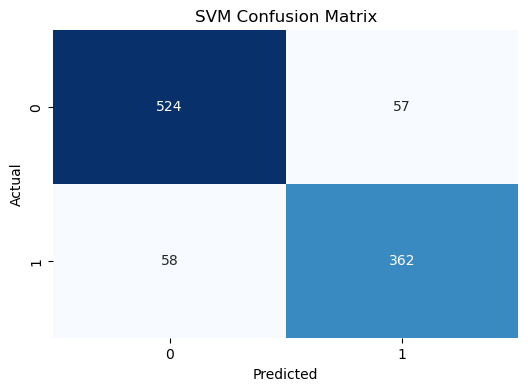

In [34]:
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_bal_test_red, svm_bal_y_pred), annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Compiled the important results into a data frame for easy understanding

All the models improved with the balanced dataset.

In [35]:
results_balance = {
    'Model': ['Random Forest', 'SVM', 'XGBoost'],
    'Accuracy': [accuracy_score(y_bal_test, rf_bal_y_pred), accuracy_score(y_bal_test, svm_bal_y_pred), accuracy_score(y_bal_test, xgb_bal_y_pred)],
    'Precision (Class 1)': [rf_bal_report['1']['precision'], svm_bal_report['1']['precision'], xgb_bal_report['1']['precision']],
    'Recall (Class 1)': [rf_bal_report['1']['recall'], svm_bal_report['1']['recall'], xgb_bal_report['1']['recall']],
    'F1-score (Class 1)': [rf_bal_report['1']['f1-score'], svm_bal_report['1']['f1-score'], xgb_bal_report['1']['f1-score']]
}
results_balance_df = pd.DataFrame(results_balance)
results_balance_df

,Model,Accuracy,Precision (Class 1),Recall (Class 1),F1-score (Class 1)
0,Random Forest,0.923077,0.925558,0.888095,0.906440
1,SVM,0.885115,0.863962,0.861905,0.862932
2,XGBoost,0.911089,0.894988,0.892857,0.893921


## Model optimization

Random Forest optimization

In [35]:
param_dist = {
    'n_estimators': [50, 100, 150],
    'max_depth': [15, 20, 25],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'log2'],
    'bootstrap': [False]
}

rf2 = RandomForestClassifier()
rf_grid = GridSearchCV(estimator=rf2, param_grid=param_dist, cv=4, verbose=1, n_jobs=-1)
rf_grid.fit(X_bal_train, y_bal_train)
best_gridparams = rf_grid.best_params_
best_gridparams

Fitting 4 folds for each of 162 candidates, totalling 648 fits


{'bootstrap': False,
 'max_depth': 15,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [36]:
rf_grid_y_pred = rf_grid.predict(X_bal_test)

print(classification_report(y_bal_test, rf_grid_y_pred))

              precision    recall  f1-score   support

           0       0.93      0.96      0.94       581
           1       0.94      0.90      0.92       420

    accuracy                           0.93      1001
   macro avg       0.93      0.93      0.93      1001
weighted avg       0.93      0.93      0.93      1001



In [55]:
rf3 = RandomForestClassifier(random_state=12,bootstrap=False, max_depth=15, max_features='log2', n_estimators=100, min_samples_leaf=1, min_samples_split=2)
rf3.fit(X_bal_train, y_bal_train)
rf3_y_pred = rf3.predict(X_bal_test)
rf3_report = classification_report(y_bal_test, rf3_y_pred, output_dict=True)
print(classification_report(y_bal_test,rf3_y_pred))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       581
           1       0.93      0.90      0.92       420

    accuracy                           0.93      1001
   macro avg       0.93      0.93      0.93      1001
weighted avg       0.93      0.93      0.93      1001



Feature Importance of the model

In [41]:
columns = X.columns
feature_imp = pd.Series(rf3.feature_importances_, index = columns).sort_values(ascending = False)
feature_imp_df = pd.DataFrame({'Feature': feature_imp.index, 'Importance': feature_imp.values*100})
feature_imp_df['Importance'] = feature_imp_df['Importance'].apply(lambda x: f'{x:.3f}%')

feature_imp_df

,Feature,Importance
0,Recency,9.439%
1,Income,7.690%
2,MntWines,7.411%
3,MntGoldProds,6.909%
4,Tenure,6.647%
5,MntMeatProducts,6.393%
6,Marital_Status_Married,5.876%
7,Marital_Status_Single,5.617%
8,Marital_Status_Together,4.796%
9,NumStorePurchases,4.764%


XGBoost optimization

In [37]:
param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [6, 7, 8, 10, 15, 20],
    'min_child_weight': [1, 2, 3, 5],
    'subsample': [0.6, 0.7, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5]
}

xgb_model2 = xgb.XGBClassifier()
xgb_grid = RandomizedSearchCV(estimator=xgb_model2, param_distributions=param_dist, n_iter=500, cv=4, verbose=2, random_state=42, n_jobs=-1)
xgb_grid.fit(X_bal_train, y_bal_train)
xgb_grid.best_params_

Fitting 4 folds for each of 500 candidates, totalling 2000 fits


{'subsample': 0.6,
 'n_estimators': 300,
 'min_child_weight': 2,
 'max_depth': 15,
 'learning_rate': 0.1,
 'gamma': 0.3,
 'colsample_bytree': 0.9}

In [38]:
xgb_grid_y_pred = xgb_grid.predict(X_bal_test)
xgb_grid_report = classification_report(y_bal_test, xgb_grid_y_pred, output_dict=True)
print(classification_report(y_bal_test, xgb_grid_y_pred))

              precision    recall  f1-score   support

           0       0.92      0.93      0.93       581
           1       0.91      0.89      0.90       420

    accuracy                           0.92      1001
   macro avg       0.92      0.91      0.91      1001
weighted avg       0.92      0.92      0.92      1001



In [45]:
xgb_model3 = xgb.XGBClassifier(random_state=10, subsample=0.6, n_estimators=300, min_child_weight = 2, max_depth=15,
                              learning_rate=0.1, gamma = 0.3, colsample_bytree = 0.9)
xgb_model3.fit(X_bal_train, y_bal_train)

xgb3_y_pred = xgb_model3.predict(X_bal_test)
xgb3_report = classification_report(y_bal_test, xgb3_y_pred, output_dict=True)
print(classification_report(y_bal_test, xgb3_y_pred))

              precision    recall  f1-score   support

           0       0.92      0.93      0.93       581
           1       0.91      0.89      0.90       420

    accuracy                           0.92      1001
   macro avg       0.92      0.91      0.91      1001
weighted avg       0.92      0.92      0.92      1001



SVM optimization

In [43]:
param_grid = {
    'C': uniform(0.1, 10),  # Regularization parameter
    'gamma': ['scale', 'auto'],  # Kernel coefficient
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']  # Kernel type
}

svm2 = SVC(probability=True)
svm_random = RandomizedSearchCV(estimator=svm2, param_distributions=param_grid, n_iter=300, cv=5, random_state=42, n_jobs=-1)
svm_random.fit(X_bal_train_scaled, y_bal_train_red)
svm_random.best_params_

{'C': 10.066368370739054, 'gamma': 'scale', 'kernel': 'rbf'}

In [44]:
svm_random_y_pred = svm_random.predict(X_bal_test_scaled)
svm_random_report = classification_report(y_bal_test_red, svm_random_y_pred, output_dict=True)
print(classification_report(y_bal_test_red, svm_random_y_pred))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91       581
           1       0.87      0.89      0.88       420

    accuracy                           0.90      1001
   macro avg       0.89      0.90      0.89      1001
weighted avg       0.90      0.90      0.90      1001



In [49]:
svm3 = SVC(random_state = 10, probability=True, C = 10.066368370739054, gamma = 'scale', kernel = 'rbf')
svm3.fit(X_bal_train_scaled, y_bal_train_red)

svm3_y_pred = svm3.predict(X_bal_test_scaled)
svm3_report = classification_report(y_bal_test_red, svm3_y_pred, output_dict=True)
print(classification_report(y_bal_test_red, svm3_y_pred))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91       581
           1       0.87      0.89      0.88       420

    accuracy                           0.90      1001
   macro avg       0.89      0.90      0.89      1001
weighted avg       0.90      0.90      0.90      1001



In [56]:
results_optimized = {
    'Model': ['Random Forest', 'SVM', 'XGBoost'],
    'Accuracy': [accuracy_score(y_bal_test, rf3_y_pred), accuracy_score(y_bal_test, svm3_y_pred), accuracy_score(y_bal_test, xgb3_y_pred)],
    'Precision (Class 1)': [rf3_report['1']['precision'], svm3_report['1']['precision'], xgb3_report['1']['precision']],
    'Recall (Class 1)': [rf3_report['1']['recall'], svm3_report['1']['recall'], xgb3_report['1']['recall']],
    'F1-score (Class 1)': [rf3_report['1']['f1-score'], svm3_report['1']['f1-score'], xgb3_report['1']['f1-score']]
}
results_optimized_df = pd.DataFrame(results_optimized)
results_optimized_df

,Model,Accuracy,Precision (Class 1),Recall (Class 1),F1-score (Class 1)
0,Random Forest,0.932068,0.933498,0.902381,0.917676
1,SVM,0.897103,0.867749,0.890476,0.878966
2,XGBoost,0.917083,0.907990,0.892857,0.900360


In [46]:
def plot_roc_curve(model1, model2, model3, X_test1, y_test1, X_test2, y_test2, label1, label2, label3):
    y_probs1 = model1.predict_proba(X_test1)[:,1]
    y_probs2 = model2.predict_proba(X_test2)[:,1]
    y_probs3 = model3.predict_proba(X_test2)[:,1]
    
    fpr1, tpr1, thresholds1 = roc_curve(y_test1, y_probs1)
    roc_auc1 = auc(fpr1, tpr1) 
    
    fpr2, tpr2, thresholds2 = roc_curve(y_test2, y_probs2)
    roc_auc2 = auc(fpr2, tpr2)

    fpr3, tpr3, thresholds3 = roc_curve(y_test2, y_probs3)
    roc_auc3 = auc(fpr3, tpr3)
    # Plot both ROC curves on the same graph
    plt.figure()
    plt.plot(fpr1, tpr1, color='darkorange', lw=2, label=f'{label1} (area = %0.2f)' % roc_auc1)
    plt.plot(fpr2, tpr2, color='blue', lw=2, label=f'{label2} (area = %0.2f)' % roc_auc2)
    plt.plot(fpr3, tpr3, color='green', lw=2, label=f'{label3} (area = %0.2f)' % roc_auc2)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()    

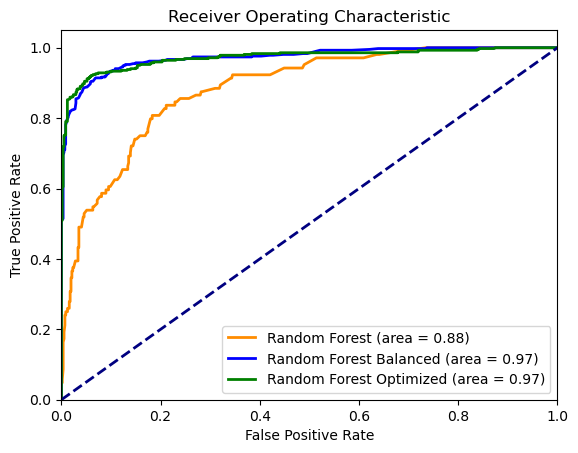

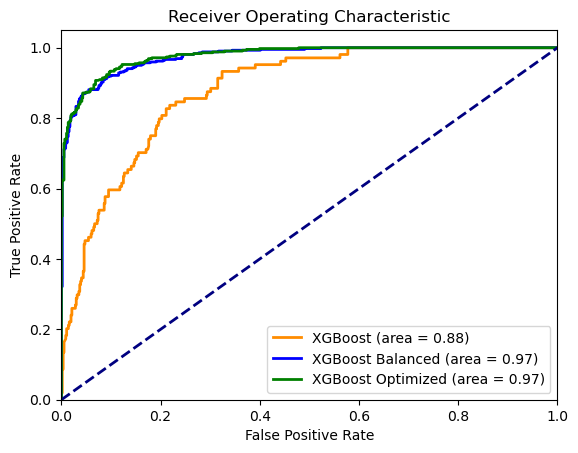

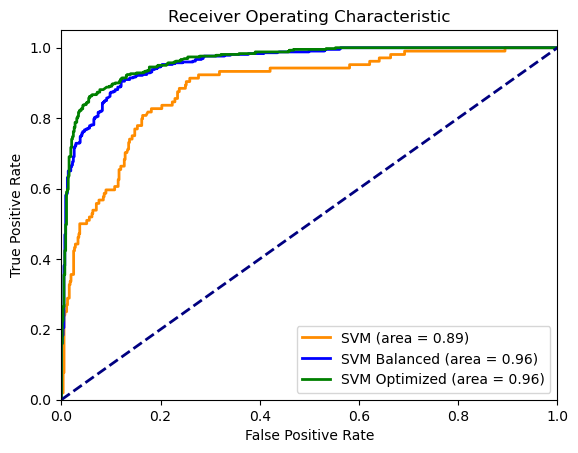

In [48]:
plot_roc_curve(rf, rf_bal, rf_grid, X_test, y_test, X_bal_test, y_bal_test, "Random Forest","Random Forest Balanced", "Random Forest Optimized")
plot_roc_curve(xgb_model, xgb_bal_model, xgb_grid, X_test, y_test, X_bal_test, y_bal_test, "XGBoost","XGBoost Balanced", "XGBoost Optimized")
plot_roc_curve(svm_classifier, svm_classifier_bal, svm_random, X_test_scaled, y_test_red, X_bal_test_scaled, y_bal_test_red, "SVM","SVM Balanced", "SVM Optimized")